#### Step 1: Install libraries

In [1]:
!pip install bitsandbytes transformers accelerate peft -q
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"
!pip install -U "huggingface_hub[cli]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.6/402.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.23.3
    Uninstalling huggingface-hub-0.23.3:
      Successfully uninstalled huggingface-hub-0.23.3


#### Step 2: Import libraries

In [1]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch
import numpy as np
import cv2
import os
import re
import matplotlib.pyplot as plt
import sys
from PIL import Image, ImageDraw, ImageFont

#### Step 3: Clone Big_Vision repository

In [2]:
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to Python import path.
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

#### Step 4: Login to HF account

In [9]:
from huggingface_hub import notebook_login

notebook_login()

#### Step 5: Load pre-trained PaliGemma model

In [10]:
from transformers import BitsAndBytesConfig
import torch
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


In [11]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device="cuda"
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16,
                                                          quantization_config=nf4_config, device_map={"":0})
processor = PaliGemmaProcessor.from_pretrained(model_id)

/home/prakhar/Desktop/Tata Competition/Tata_Innovent_2024/Tata/lib64/python3.12/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 3.71 GiB of which 5.81 MiB is free. Including non-PyTorch memory, this process has 3.70 GiB memory in use. Of the allocated memory 3.59 GiB is allocated by PyTorch, and 24.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Step 6: Load input image and text prompt for PaliGemma

In [4]:
input_img = "/home/prakhar/Desktop/Tata Competition/Car dentss.v1i.coco-segmentation/test/car-accident-4991518_jpg.rf.091d3e55eabfff97db47712ddce9a10e.jpg" # @param {type:"string"}
input_image = Image.open(input_img)
width, height = input_image.size

prompt = "car" # @param {type: "string"}
prompt = prompt.replace(',', '\n')

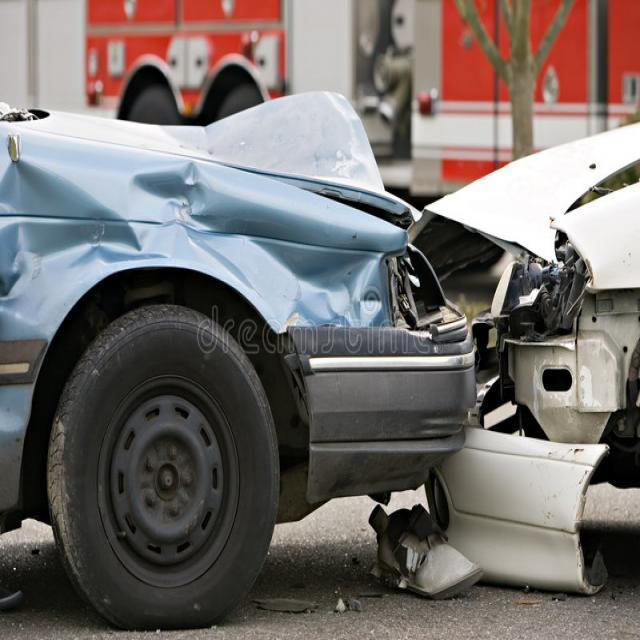

In [5]:
input_image

In [7]:
inputs = processor(text=prompt, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt")
model.to(device)
inputs = inputs.to(dtype=model.dtype)

You shouldn't move a model that is dispatched using accelerate hooks.


ValueError: `.to` is not supported for `4-bit` or `8-bit` bitsandbytes models. Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`.

In [86]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

paligemma_response = processor.decode(output[0], skip_special_tokens=True)[len(prompt):].lstrip("\n")
detections = paligemma_response.split(" ; ")

#### Step 7: Parse segmentation output

In [87]:
import big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval
reconstruct_masks = segeval.get_reconstruct_masks('oi')

def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      + ''.join(f'<seg(?P<s{i}>\d\d\d)>' for i in range(16)),
      detokenized_output,
  )
  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])

  coordinates = boxes[0]
  mask = np.array(reconstruct_masks(np.array(segs)))

  return coordinates, mask

#### Step 8: Draw segmentation mask

In [88]:
def show_segmentation_output(image, segment_masks, image_size, coordinates_list, labels):

  height, width = image_size
  label_colors = {}
  masked_image = Image.fromarray(np.uint8(image.copy()))

  for i, segment_mask in enumerate(segment_masks):
    coordinates = coordinates_list[i]
    label = labels[i]

    if label not in label_colors:
      label_colors[label] = (np.random.randint(256), np.random.randint(256), np.random.randint(256), 128)

    y1, x1, y2, x2 = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    y1, x1, y2, x2 = map(round, (y1*height, x1*width, y2*height, x2*width))

    # Get mask width and height.
    w = x2 - x1
    h = y2 - y1

    # Scale the mask
    x_scale = w / 64
    y_scale = h / 64

    # Create coordinate grids for the new image.
    x_coords = np.arange(w)
    y_coords = np.arange(h)
    x_coords = (x_coords / x_scale).astype(int)
    y_coords = (y_coords / y_scale).astype(int)

    # Resize segment mask based on scaling factors.
    resized_segmend_mask = segment_mask[y_coords[:, np.newaxis], x_coords]

    resized_segmend_mask = np.squeeze(resized_segmend_mask)

    pil_image = Image.fromarray(np.uint8(image))

    mask = Image.new('RGBA', pil_image.size, (0, 0, 0, 0))
    draw = ImageDraw.Draw(mask)

    # Draw the mask on the image.
    for y in range(h):
      for x in range(w):
        if resized_segmend_mask[y, x] > 0:
          draw.point((x, y), fill=label_colors[label])


    masked_image.paste(mask, (x1, y1), mask)

  blended_np = np.array(masked_image.convert('RGB'))

  # Overlay the legend on the image.
  legend_y = int(height * 0.03)
  legend_box_width = int(width * 0.05)  # Add padding for text
  legend_box_height = int(height * 0.04)
  for idx, (label, color) in enumerate(label_colors.items()):
    legend_entry_x1 = int(width * 0.84)
    legend_entry_y1 = legend_y
    legend_entry_x2 = legend_entry_x1 + legend_box_width
    legend_entry_y2 = legend_y + legend_box_height
    cv2.rectangle(blended_np, (legend_entry_x1, legend_entry_y1), (legend_entry_x2, legend_entry_y2), color[:3], -1)

    text = label
    text_x = int(width * 0.90)  # Adjust for padding
    text_y = legend_y + (legend_box_height // 2) + 5  # Center vertically in the box

    cv2.putText(blended_np, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    legend_y += legend_box_height + max(height // 200, 5)

  masked_output = Image.fromarray(blended_np.astype('uint8'), 'RGB')

  return masked_output

In [89]:
segment_masks = []
coordinates_list = []
labels = []

for detection in detections:
  detection = detection.split(" ")
  locations, segmentations, label = detection[0], detection[1], detection[2]
  paligemma_output = locations + segmentations
  bbox, seg_output = parse_segments(paligemma_output)
  segment_masks.append(seg_output[0])
  coordinates_list.append(bbox)
  labels.append(label)

masked_output = show_segmentation_output(input_image, segment_masks, (height, width), coordinates_list, labels)

#### Step 9: Display final output

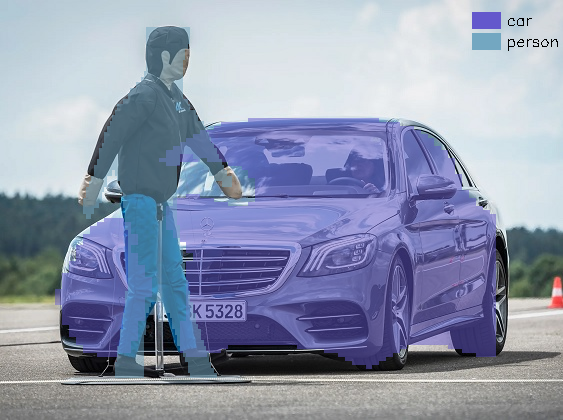

In [90]:
masked_output